In [2]:
from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json

# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits



file = Path(r"G:\MeOH_test\NFL\T56_NFL_Cam_5_experiement.cine")
# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file)

# Normalize the grayscale video to [0, 1] brightness range
video = video / brightness_levels

json_file = Path(r"G:\MeOH_test\NFL\config.json")
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 401
The injector has 1 plumes.
The nozzle is centred at (622.00, 65.00) in image coordinates.


In [3]:
from OSCC_postprocessing.playback.video_playback import *
play_video_cv2(video, intv=17)


In [4]:
# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


In [5]:
# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


(622.0, 65.0)

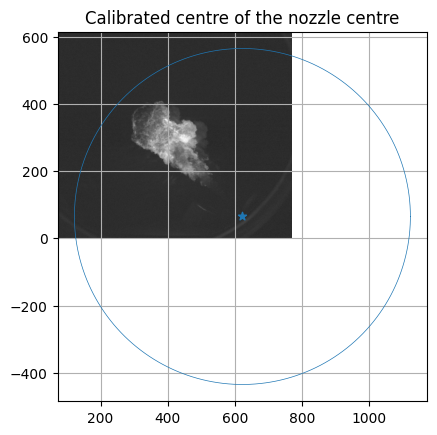

In [6]:
r =500

# Displaying the clibration
plt.imshow(video[50]**0.5, cmap="gray")
plt.scatter(centre[0], centre[1], marker="*")

theta = np.linspace(0, 2*np.pi, 400)

x0, y0 = centre[0] , centre[1]

x = x0 + r * np.cos(theta)
y = y0 + r * np.sin(theta)

plt.plot(x, y, linewidth="0.5")
# plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
# plt.show()

plt.xlim([centre[0]-1.1*r, centre[0]+1.1*r])
plt.ylim([centre[1]-1.1*r, centre[1]+1.1*r])
plt.title("Calibrated centre of the nozzle centre")
centre



In [7]:
# Rotation


# Frames, Height, Width
F, H, W = video.shape

# Image rotation settings
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

# Arbitrary rotated image strip shape
OUT_SHAPE = (or_//3, or_)

video = cp.asarray(video)

segment, _, _ = rotate_video_nozzle_at_0_half_backend(
        video,
        centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
        # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
        offset,
        interpolation=INTERPOLATION,
        border_mode=BORDER_MODE,
        out_shape=OUT_SHAPE,
    )




In [9]:
play_video_cv2(segment.get(), intv=17)

In [12]:

from OSCC_postprocessing.filters.bilateral_filter import *
# upload to gpu or do nothing with cpu

# pakaged pre-processing calling, use this in real impelmentations
# foreground = pre_processing_mie(video, division=False)

# Explicitly coding for showing the whole process

# We do not divide by the first frame to fix lighting
# In the videos I process, they have some strong bright spots by reflections
# If didivde, they become some dark spots. 


# For single plume, rotate & crop before filtering 

# Bilateral filtering
if use_gpu:
    bilateral_filtered = bilateral_filter_video_cupy(segment, 7, 3, 3)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(segment), 7, 3, 3)



# Take the filtered first frame as background 
bkg = bilateral_filtered[0]
bkg[bkg == 0] = 1e-9
bkg[bkg == cp.nan] = 1e-9

# Foreground is the filtered video - filtered background
foreground = bilateral_filtered - bilateral_filtered[0][None, :, :]

In [ ]:
play_video_cv2(foreground.get())

In [13]:
td_map = xp.sum(foreground, axis=1).T

Text(0, 0.5, 'pixels')

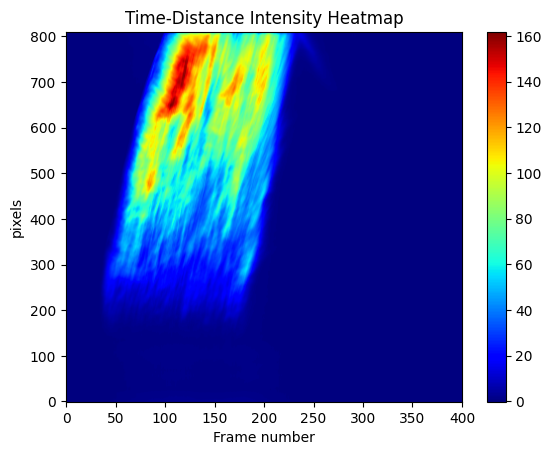

In [14]:
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar()
plt.xlabel("Frame number")
plt.ylabel("pixels")

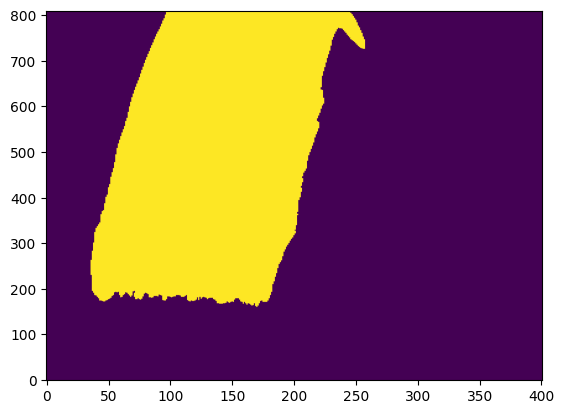

In [15]:
from OSCC_postprocessing.analysis.single_plume import *
from OSCC_postprocessing.binary_ops.functions_bw import *
 

bw = keep_largest_component_cuda(
            triangle_binarize_gpu(
                _min_max_scale(td_map))
                , connectivity=2)

plt.imshow(bw.get(), origin="lower", aspect="auto") # type: ignore


In [16]:
def longest_true_run(mask):
    """返回最长 True 连续段的 (start, end_exclusive)，若无 True 返回 None。"""
    """Retruan the longest True duration"""
    m = mask.astype(bool)
    if not m.any():
        return None
    diff = np.diff(m.astype(np.int8))
    starts = np.where(diff == 1)[0] + 1
    ends   = np.where(diff == -1)[0] + 1
    if m[0]:
        starts = np.r_[0, starts]
    if m[-1]:
        ends = np.r_[ends, len(m)]
    lengths = ends - starts
    k = np.argmax(lengths)
    return int(starts[k]), int(ends[k])

In [17]:
flame_front = bw.shape[0] - cp.argmax(bw[::-1, :], axis=0)
flame_front = flame_front.astype(cp.float32)
flame_front[flame_front == bw.shape[0]] = cp.nan

flame_lift_off =  cp.argmax(bw, axis=0).astype(cp.float32)
flame_lift_off[flame_lift_off == 0.0] = cp.nan 

TF = ~cp.isnan(flame_front)

start, end = longest_true_run(TF.get())

flame_front[:start] = cp.nan
flame_front[end:] = cp.nan


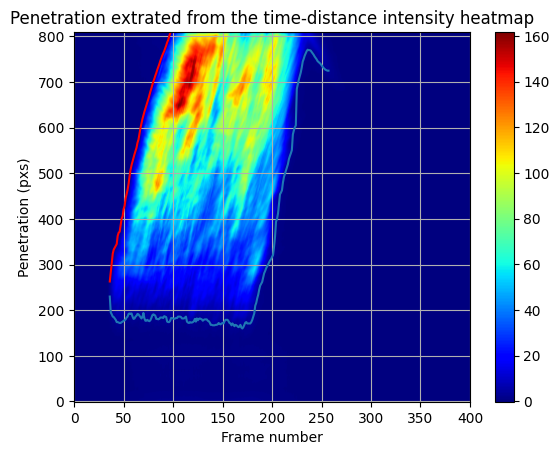

In [19]:

plt.plot(flame_lift_off.get())

plt.plot(flame_front.get(), color="r")
plt.imshow(td_map.get(), origin="lower", aspect="auto", cmap="jet")
plt.title("Penetration extrated from the time-distance intensity heatmap")
plt.xlabel("Frame number")
plt.ylabel("Penetration (pxs)")
plt.colorbar()
plt.grid()